## Реализация архитектуры Transformer своими руками
---
**Разработчик: Денис Кузнеделев**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/puhsu/dl-hse/blob/main/week05-transformers/shw4/homework.ipynb)

### Introduction
---

В данной МДЗ мы будем реализовывать компоненты архитектуры Трансформер.

Начиная со статьи [Attention Is All You Need](https://arxiv.org/abs/1706.03762), трансформеры применяются во всевозможных задачах и установили state-of-the-art на множестве бенчмарков. Первоначально они добились успеха в задачах NLP, но затем были успешно применены и в других областях - обработке сигналов, CV и даже RL.

Ниже будет дано описание отдельных модулей и код, который нужно будет написать на основе описания.

### Required imports
---

In [1]:
# run if in colab
!git clone https://github.com/puhsu/dl-hse.git
%cd dl-hse/2023/week05-transformers//shw4

Cloning into 'dl-hse'...
remote: Enumerating objects: 374, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (187/187), done.
remote: Total 374 (delta 141), reused 208 (delta 91), pack-reused 91 (from 1)
Receiving objects: 100% (374/374), 76.24 MiB | 26.26 MiB/s, done.
Resolving deltas: 100% (167/167), done.
/content/dl-hse/2023/week05-transformers/shw4


In [2]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from check import check_task_1, check_task_2, check_task_3, check_task_4

In [ ]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
# set fonttype
matplotlib.rcParams['pdf.fonttype'], matplotlib.rcParams['ps.fonttype']  = 42, 42

%matplotlib inline

In [4]:
# do not forget to choose CUDA runtime!
device = torch.device('cuda')

In [5]:
# fix seeds for reproducbility
np.random.seed(42);
torch.random.manual_seed(42);

### Scaled Dot Product Attention
---

В оригинальной работе [Attention Is All You Need](https://arxiv.org/abs/1706.03762) в качестве механизма внимания
был использован scaled dot product attention - нормализованное скалярное произведение между key и query.
На вход подается набор запросов $Q\in\mathbb{R}^{L\times d_k}$, ключей $K\in\mathbb{R}^{L\times d_k}$  и
значений  $V\in\mathbb{R}^{L\times d_v}$, где $L$ - длина последовательности, а $d_k, d_v$ - размерности query/key и value соотвественно.
Значение attention от элемента $i$ на элемент $j$ зависит от похожести query $q_i$ и key $k_j$. Attention определяется по следующей формуле:

$$ \text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

Произведение матриц $Q K^{T}$ составлено из всех попарных скалярных произведений ключей и значений.


<p align="center">
  <img src="scaled_dot_product_attn.png" width="300"/>
</p>

Дополнительно в операцию может входить бинарная маска $M \in \{0, 1\}$, зануляющая некоторые элементы в матрице attention, если по некоторой причине мы не хотим, чтобы токен $i$ из query взаимодействовал c $j$ из key. Это может быть полезно при генерации последовательностей, когда мы не хотим, чтобы данный токен смотрел вперед, на еще не сгенерированные элементы.


Деление на $\sqrt{d_k}$ необходимо, что выход операции сохранял дисперсию распределения, т.к:
$$
q_i \sim \mathcal{N}(0, 1), k_i \sim \mathcal{N}(0, 1) \to \text{Var}\left(\sum_{i=1}^{d_k} q_i\cdot k_i\right) = d_k
$$

**Задание 1 (0.1 балла):**. Реализуйте операцию scaled dot product.

In [6]:
def scaled_softmax_attention(query, key, value):
    """
    Args:
        query: torch.Tensor (..., L, D)
        key: torch.Tensor (..., L, D)
        value: torch.Tensor (..., L, D)
    Returns:
        res: torch.Tensor (..., L, D), output of the attention layer (\softmax(Q K^T / d) V
        attention: torch.Tensor (..., L, L), attention weights (\softmax(Q K^T / d))

    L is the length of sequence, D is the embedding dimension
    """
    multip = torch.matmul(query, torch.transpose(key, -2, -1))
    multip_scale = multip / torch.sqrt(torch.tensor(query.shape[-1]))
    attention = F.softmax(multip_scale, dim=-1)

    return torch.matmul(attention, value), attention

In [ ]:
query = torch.tensor([[ 0.3367,  0.1288,  0.2345,  0.2303],
                      [-1.1229, -0.1863,  2.2082, -0.6380],
                      [ 0.4617,  0.2674,  0.5349,  0.8094]])

key   = torch.tensor([[ 1.1103, -1.6898, -0.9890,  0.9580],
                      [ 1.3221,  0.8172, -0.7658, -0.7506],
                      [ 1.3525,  0.6863, -0.3278,  0.7950]])

value = torch.tensor([[ 0.2815,  0.0562,  0.5227, -0.2384],
                      [-0.0499,  0.5263, -0.0085,  0.7291],
                      [ 0.1331,  0.8640, -1.0157, -0.8887]])

In [8]:
res, attn = scaled_softmax_attention(query, key, value)
res, attn

(tensor([[ 0.1212,  0.5156, -0.2394, -0.1912],
         [ 0.0999,  0.5376, -0.2558, -0.1143],
         [ 0.1347,  0.5492, -0.3328, -0.3267]]),
 tensor([[0.3017, 0.3098, 0.3884],
         [0.2451, 0.3802, 0.3748],
         [0.2938, 0.2293, 0.4769]]))

**Sanity check**.

Матрица attn должна быть размера $(L, L)$ и столбцы должны суммироваться в 1.

In [9]:
attn.shape

torch.Size([3, 3])

In [10]:
attn.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000])

In [11]:
check_task_1(res, attn)

 Well done :)


### Multihead Attention Layer
---

Scaled dot product attention задает правило, по которому элементы последовательности взаимодейтсвуют друг с другом. Но может быть полезно задавать несколько различных правил взаимодействия. Поэтому последовательности $Q, K, V$ разбиваются на $h$
частей вдоль размерности эмбединнга, и для каждой из них независимо считаем attention, а затем конкатенируем результат. К сконкатенированному результату применяется линейное преобразование $W_O$:

$$
\begin{split}\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}\end{split}
$$

Обучаемыми параметрами являются матрицы проекции $W_Q, W_K, W_V$ и $W_O$.
Ниже приведен граф вычислений:
<p align="center">
  <img src="multihead_attention.png" width="300"/>
</p>

**Задание 2 (0.1 балла):**. Реализуйте класс  `MultiheadAttention`, реализующий операции, описанные выше.

<span style="color:red">Замечание</span>.

Обратите внимание, что слои `q_proj`, `k_proj`, `v_proj` создают последовательность для всех голов одноновременно, то есть их выходная размерность должна быть $\mathbb{R}^{d_{embed}}$, а не $\mathbb{R}^{d_{embed} / h}$.

In [12]:
from util import hardcode_parameters

In [13]:
class MultiheadAttention(nn.Module):

    def __init__(self, embed_dim, num_heads):
        """
        Args:
            embed_dim: dimensionality of embedding (total)
            num_heads: number of heads (must divide embed_dim)
        """
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    # original implementation uses this initialization
    def _reset_parameters(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    layer.bias.data.fill_(0)

    def forward(self, x, return_attention=False):
        """
        Args:
            x: torch.Tensor (B, L, D)
            return_attention: If specified, returns attention along with outputs
        Returns:
            outputs: torch.Tensor (B, L, D)
            attention: Optional[torch.Tensor] (B, num_heads, L, L)

        B is batch size, L is the length of sequence, D is the embedding dimension
        """
        q = self.q_proj(x).view(x.shape[0], x.shape[1],
                                      self.num_heads, self.head_dim
                                      ).transpose(1, 2)

        k = self.k_proj(x).view(x.shape[0], x.shape[1],
                                      self.num_heads, self.head_dim
                                      ).transpose(1, 2)

        v = self.v_proj(x).view(x.shape[0], x.shape[1],
                                      self.num_heads, self.head_dim
                                      ).transpose(1, 2)

        o, attention = scaled_softmax_attention(q, k, v)

        o = o.transpose(1, 2).reshape(x.size())
        out = self.o_proj(o)

        if return_attention:
            return out, attention
        else:
            return out

In [14]:
multihead_attention = MultiheadAttention(4, 2)

In [15]:
hardcode_parameters(multihead_attention)

In [16]:
inputs  = torch.stack([torch.cos(i * torch.ones(4)) for i in range(3)])[None, ...]

with torch.no_grad():
    outputs = multihead_attention(inputs)

In [17]:
check_task_2(outputs)

 Well done :)


### Encoder Block
---

Архитектура трансформера в оригинальной статье состоит из последовательности блоков энкодера и декодера.

<p align="center">
  <img src="transformer_architecture.png" width="300" />
</p>

В данной МДЗ необходимо будет реализовать только энкодер.

Блок энкодера состоит из операции `MultiheadAttention` и применения `FeedForward` сети к каждому токену по отдельности.

К выходу `MultiheadAttention` и `FeedForward`
прибавляется skip connection, и к полученной сумме применяется `LayerNormalization`.

В качестве `FeedForward` сети берется простая двуслойная сеть с некоторой активацией (обычно  `ReLU` или `GELU`).

Таким образом, энкодер выполняет следующее:
$$
x = \text{LayerNorm}(x+\text{MultiheadAttention}(x,x,x))
$$
$$
\begin{split}\begin{split}
    \text{FFN}(x) & = \mathrm{Act}(x W_1 + b_1) W_2 + b_2\\
    x & = \text{LayerNorm}(x + \text{FFN}(x))
\end{split}\end{split}
$$

В целях регуляризации на выход `MultiheadAttention` и `FeedForward`, но перед `LayerNorm` можно накинуть `Dropout`.

**Задание 3 (0.1 балла):**. Реализуйте класс  `EncoderBlock`, реализующий операции, описанные выше.

In [18]:
class EncoderBlock(nn.Module):

    def __init__(self, embed_dim, num_heads, feedforward_dim, activation=nn.ReLU, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            feedforward_dim - Dimensionality of the hidden layer in the MLP
            activation - activation function in FFN
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        self.MHAttention = MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, feedforward_dim),
            activation(),
            nn.Linear(feedforward_dim, embed_dim))

        self.attention_layernorm = nn.LayerNorm(embed_dim)
        self.ffn_layernorm = nn.LayerNorm(embed_dim)

        self.attention_dropout = nn.Dropout(dropout)
        self.ffn_dropout = nn.Dropout(dropout)


    def forward(self, x, return_attention=False):
        """
        Args:
            x: torch.Tensor (B, L, D)
        Returns:
            outputs: torch.Tensor (B, L, D)
            attention: Optional[torch.Tensor] (B, num_heads, L, L)
        """
        o, attention = self.MHAttention(x, return_attention=True)
        o = self.attention_layernorm(self.attention_dropout(o) + x)

        skip_connection = o
        o = self.ffn(o)
        o = self.ffn_layernorm(self.ffn_dropout(o) + skip_connection)

        if return_attention:
            return o, attention
        else:
            return o



### Positional Encoding
---

Описанная выше конструкция очень гибкая и универсальная в плане возможности преобразования последовательностей.
Но есть один нюанс: абсолютное положение токенов никак не определено в текущей форме, и операция `EncoderBlock`
обладает перестановочной симметрией. То есть, если переставить токены в последовательности, то выход от переставленной последовательности будет таким же, как если прогнать исходную последовательность, а затем ее переставить.

Сгенерируем рандомную последовательность.

In [19]:
encoder_block = EncoderBlock(embed_dim=24, num_heads=3, feedforward_dim=24 * 4, dropout=0.0)

In [20]:
inputs = torch.randn(1, 16, 24)

Выход от исходной последовательности

In [21]:
outputs = encoder_block(inputs)

Сгенерируем случайную перестановку

In [22]:
ids_perm = torch.randperm(inputs.size(1))
shuffled_inputs = inputs[:, ids_perm, :]

Посчитаем выход для переставленной последовательности

In [23]:
shuffled_outputs = encoder_block(shuffled_inputs)

И сравним переставленный выход исходной последовательности с выходом переставленной

In [24]:
torch.allclose(outputs[:, ids_perm, :], shuffled_outputs, atol=1e-4, rtol=1e-4)

True

Вуаля! Совпадают.

Но во многих задачах важен порядок, и чтобы его каким-то образом учесть добавляют так называемый PositionalEncoding, который явно задает информацию о положении токена в последовательности. Он может быть как обучаемым, так и зафиксированным.
В оригинальной работе Attention is all you need был выбран следующий энкодинг и синусов и косинусов разных частот:

$$
\begin{split}PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}\end{split}
$$

$PE_{(pos,i)}$ обозначает позиционный энкодинг токена в позиции $pos$, а $i$ нумерует размерность эмбеддинга.

**Задание 4 (0.1 балла):**. Реализуйте класс  `PositionalEmbedding`, добавляющий позиционный энкодинг определенный выше к входной последовательности.

In [25]:
class PositionalEncoding(nn.Module):

    def __init__(self, embed_dim, max_len: int = 5000):
        """
        Inputs
            embed_dim - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()
        # TODO
        pe = torch.zeros(max_len, embed_dim)
        positions = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        frs = torch.exp(torch.arange(0, embed_dim, 2,
                                     dtype=torch.float) * \
                          (-math.log(10000) / embed_dim)).unsqueeze(0)

        args = positions * frs
        pe[:, 0::2], pe[:, 1::2] = torch.sin(args), torch.cos(args)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        return x + self.pe[:, :x.shape[1]]

Визуализируем энкодинг

In [26]:
positional_encoding = PositionalEncoding(embed_dim=64, max_len=128)
pe = positional_encoding.pe[0]

In [27]:
check_task_3(pe)

 Well done :)


In [28]:
pe = positional_encoding.pe.numpy()[0]

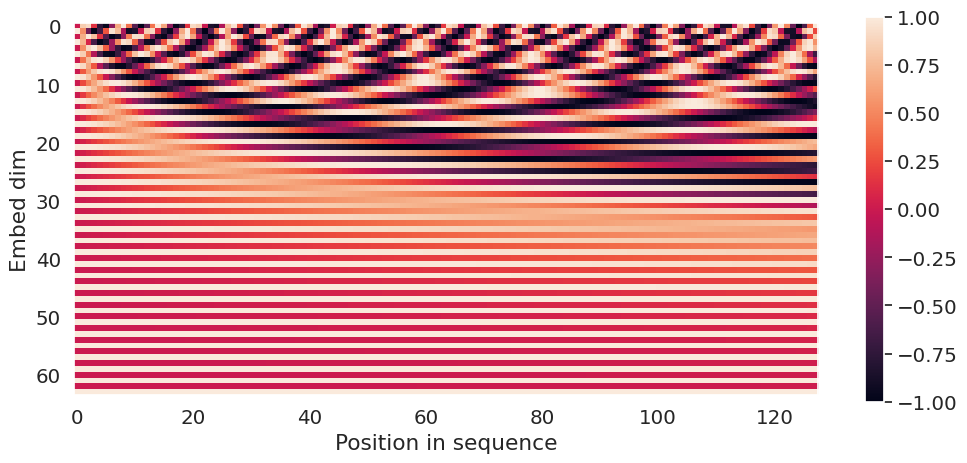

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))

im = ax.imshow(pe.T)
ax.grid(False)

ax.set_ylabel(r'Embed dim')
ax.set_xlabel(r'Position in sequence')

fig.colorbar(im, ax=ax);

Implementation check

In [30]:
check_task_4(positional_encoding)

 Well done :)


### Transformer
---

Теперь у нас есть все необходимые компоненты, чтобы собрать трансформер своими руками.
Сам по себе трансформер может выполнять великое множество задач, но в рамках данной МДЗ мы ограничимся задачей классификации последовательностей.

Архитектура состоит из следующих компонент:
- Линейное преобразование входной последовательности : $\mathbb{R}^{d_{in}} \rightarrow \mathbb{R}^{d_{embed}}$, примененное поэлементно к каждому токену
- Один или несколько блоков `EncoderBlock`
- `PositionalEmbedding`
- Для задачи классификации создается специальный токен `[CLS]`, который прибавляется в начало (или конец последовательности)
- `[CLS]` токен, пропущенный через последовательность, подается на вход классификатора (скажем, линейного слоя $\mathbb{R}^{d_{embed}} \rightarrow \mathbb{R}^{|C|}$, $|C|$ - число классов).

**Задание 5 (0.2 балла):** Реализуйте класс  `TransformerForSequenceClassification`, принимающий на вход последовательность и предсказывающий ее класс.

In [31]:
class TransformerForSequenceClassification(nn.Module):
    def __init__(
        self,
        input_dim: int,
        embed_dim: int,
        num_classes: int,
        num_heads: int,
        feedforward_dim: int,
        num_layers: int,
        activation = nn.GELU,
        max_len: int = 5000,
        dropout: float = 0.0
    ):
        super().__init__()
        # define layers
        self.cls_token = torch.rand(embed_dim)
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len)

        self.encoder = nn.ModuleList([EncoderBlock(embed_dim,
                                       num_heads,
                                       feedforward_dim,
                                       activation,
                                       dropout) for i in range(num_layers)])

        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward_attention(self, x):
        """
        This method returns attention maps from all encoder blocks

        Args:
            x: torch.Tensor (B, L, |V|)
        Returns:
            attn: List[torch.Tensor] (B, num_heads, L+1, L+1) x num_layers
        """
        attentions = []
        x = self.positional_encoding(self.input_embedding(x))
        x = torch.cat((x, self.cls_token.repeat(x.shape[0], 1, 1).cuda()), dim=1)

        for l in self.encoder:
            x, attention = l(x, return_attention=True)
            attentions.append(attention)

        return attentions

    def forward(self, x):
        """
        Args:
            x: torch.Tensor (B, L, |V|)
        Returns:
            x: torch.Tensor (B, |C|)
        """
        x = self.positional_encoding(self.input_embedding(x))
        x = torch.cat((x, self.cls_token.repeat(x.shape[0], 1, 1).cuda()), dim=1)

        for l in self.encoder:
            x = l(x)

        x = self.classifier(x[:, -1, :])
        return x

### Data
---
В данной МДЗ в качестве задачи, которой мы будем обучать трансформер, является определение того, является ли строка палиндромом. То есть тождественна ли строка, написанная задом наперед, исходной строке.

$$
a b f g a a g f b a \quad \mathrm{\ is \ a \ palindrome}
$$

Последовательности генерируются случайным образом из некоторого слова размера `vocab_length`.

In [32]:
from functools import partial
from torch.utils.data import DataLoader
from dataset import PalindromeDataset

In [33]:
vocab_length = 33
sequence_length = 256

make_dataset = partial(
    PalindromeDataset,
    vocab_length=vocab_length,
    sequence_length=sequence_length
)

Созданим обучающую и тестовую выборку

In [34]:
train_dataset = make_dataset(size=50000)
val_dataset = make_dataset(size=10000)

In [35]:
# training hyperparameters
batch_size = 128
num_workers = 2

In [36]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True
)
val_loader  = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

In [37]:
# model hyperparams
embed_dim = 64
num_heads = 2
feedforward_dim = 128
num_layers =  3

In [38]:
model = TransformerForSequenceClassification(
    num_classes=1,
    input_dim=vocab_length,
    embed_dim=embed_dim,
    num_heads=num_heads,
    feedforward_dim=feedforward_dim,
    activation=nn.ReLU,
    num_layers=num_layers
)
# put model on device
model = model.to(device)

Есть мнение, что если обучать сразу Transformer без предварительного 'разогрева', то обучение может разойтись, или долго и тяжело сходиться к оптимуму. На рисунке ниже приведено поведение кривых обучения без и с разогревом (синяя, без).

<p align="center">
  <img src="warmup_loss_plot.png" width="500" />
</p>

 Поэтому на практике при обучение трансформеров принято использовать расписание с 'разогревом', когда первое время, заданное количество шагов оптимизатора или эпох, `learning rate` сначала линейно растет, а затем затухает. Ниже мы будем использовать косинусное затухание.

In [39]:
from util import CosineAnnealingWithWarmupLR

Визуализируем расписание

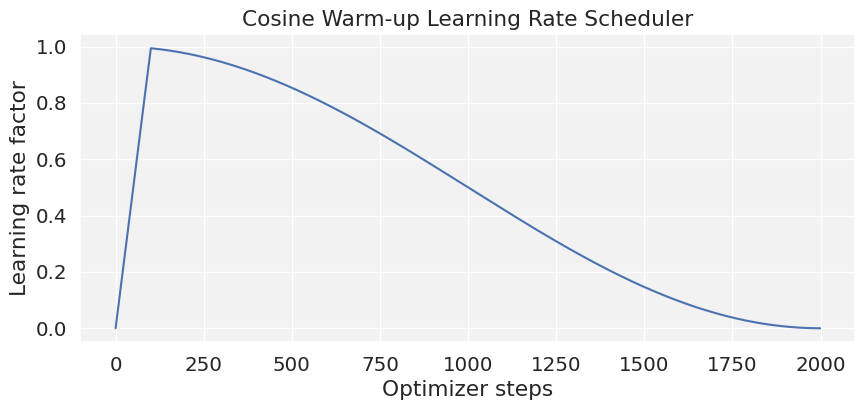

In [40]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4, 4))
optimizer = torch.optim.Adam([p], lr=1e-3)
lr_scheduler = CosineAnnealingWithWarmupLR(optimizer=optimizer, warmup_steps=100, max_steps=2000)

# Plotting
fig, ax = plt.subplots(figsize=(10, 4))
steps = range(2000)

ax.plot(steps, [lr_scheduler.get_lr_factor(e) for e in steps])
ax.set_ylabel("Learning rate factor")
ax.set_xlabel("Optimizer steps")
ax.set_title("Cosine Warm-up Learning Rate Scheduler");

**Задание 6 (0.1 балла):** обучите модель-классификатор палиндромов.

In [41]:
from util import train

Зададим параметры обучения и оптимизатора

In [42]:
num_epochs = 40
warmup_steps = 2000
lr = 3e-4

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)

scheduler = CosineAnnealingWithWarmupLR(
    optimizer,
    warmup_steps=warmup_steps,
    max_steps=int(num_epochs * len(train_loader))
)

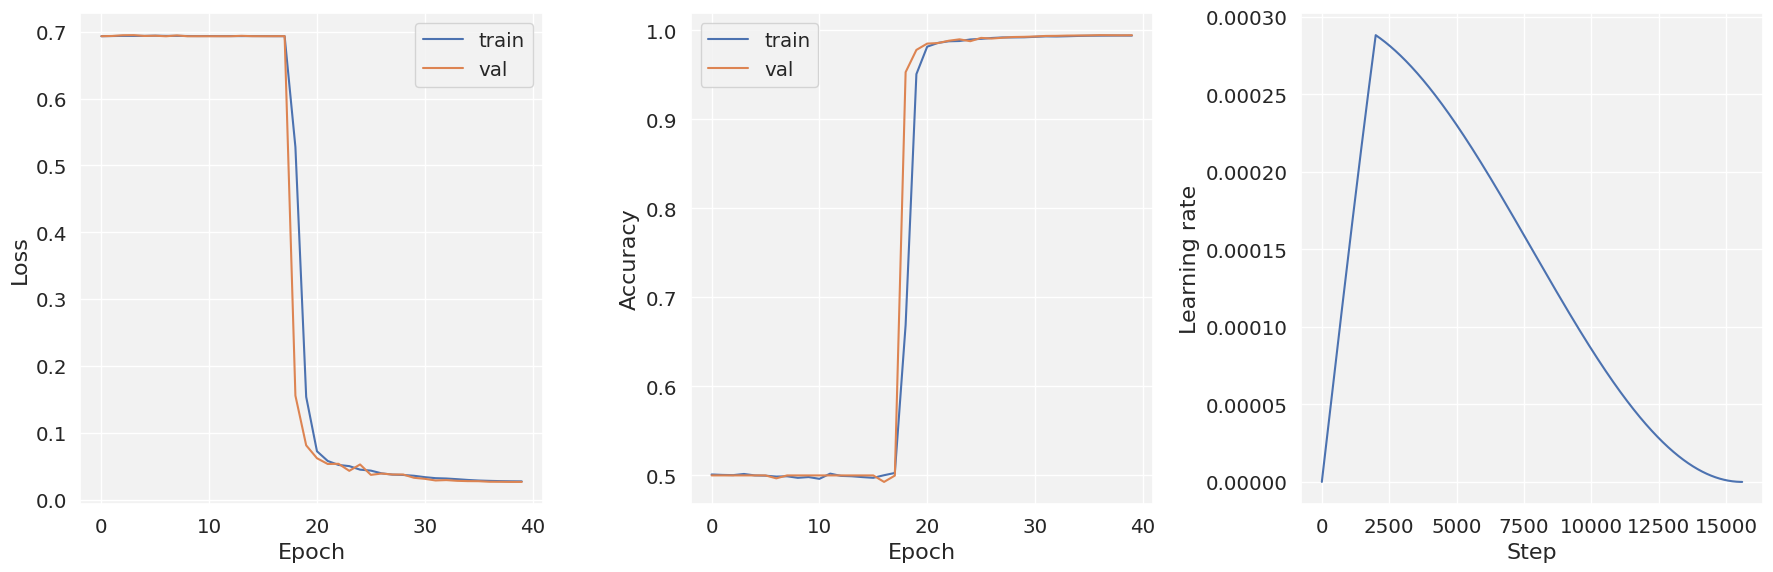

In [47]:
train(
    model,
    num_epochs=num_epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device
)

Если все было реализовано верно, то модель должна выдавать качество > 95%

### Linformer
---

Механизм Attention очень мощный, но имеет существенный недостаток при работе с длинными последовательностями.

Как нетрудно заметить, операция $Q K^{T}$ квадратична по длине последовательности по сложности вычислений и занимаемой памяти.

Что может быть критично, если контекст важный для данного токена имеет длину более 1000 токенов. Было предложено множество подходов по замене или приближению операции  Attention на нечто имеющее субквадратичную сложность по длине последовательности. Для желающих узнать больше есть [хороший обзор по теме](https://lilianweng.github.io/posts/2020-04-07-the-transformer-family/), а в данной МДЗ будет предложено реализовать [Linformer](https://arxiv.org/abs/2006.04768).

Возьмем ранее обученную модель и ее матрицу `Attention`. Одной из основных характеристик матрицы является ее ранг и разложение по сингулярным числам. Если большая часть массы собственных/сингулярных значений концентрируется на первых нескольких собственных векторах, то эффективно матрица является отображением в пространство низкой размерности.

Здесь можно вспомнить принцип работы `PCA`, где уменьшение размерности достигается за счет проекция на несколько первых сингулярных векторов. Построим нормализованную кумулятивную сумму первых $k$-собственных значений (известную в литературе как Explained Variance).

In [44]:
sequence, label = val_dataset[0]

In [45]:
with torch.no_grad():
    # we take attention only from the last layer
    attn = model.forward_attention(sequence[None, ...].to(device))[-1]

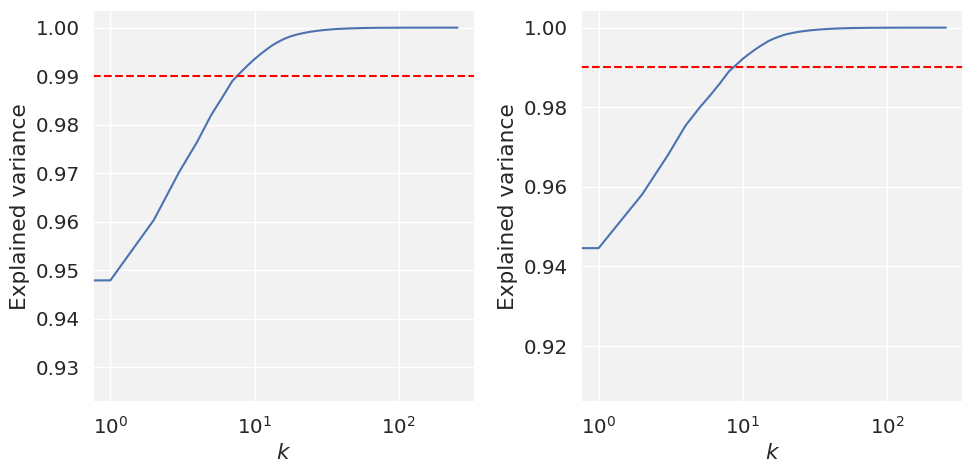

In [46]:
# select number such that num_heads divides it
heads_per_row = 2

fig, ax = plt.subplots(
    nrows=num_heads // heads_per_row,
    ncols=heads_per_row,
    figsize=(heads_per_row * 5, (num_heads // heads_per_row) * 5),
    squeeze=False
)

for head_idx in range(num_heads):
    row, col = head_idx // heads_per_row, head_idx % heads_per_row
    sing_vals = torch.linalg.svdvals(attn[0, head_idx, 1:, 1:]).cpu().numpy()
    expl_var  = np.cumsum(sing_vals ** 2, axis=0)
    expl_var /= expl_var[-1]
    ax[row, col].plot(expl_var)
    ax[row, col].axhline(0.99, linestyle='--', color='red')
    ax[row, col].set_xlabel(r'$k$')
    ax[row, col].set_ylabel(r'Explained variance')
    ax[row, col].set_xscale('log')

fig.tight_layout()

Что вы наблюдаете?

Отсюда и берет начало идея `Linformer`.

Так как матрица Attention низкоранговая, вместо того чтобы считать большую квадратную матрицу $L \times L$, предлагается вычислять прямоугольную
$L \times k$, где $k \ll L$.

Последовательности $K$ и $V$ (после прогонки через $W_K$, $W_V$) отображаются вдоль оси, отвечающей длине последовательности из $L$ - мерного пространства в $k$ - мерное. И только затем вычисляется скалярное произведение уже с $k$ ключами для всех query.

<p align="center">
  <img src="LinformerAttention.png" width="300" />
</p>

Вычислительная сложность уменьшается с $\mathcal{O}(L^2)$ до $\mathcal{O}(L k)$.

В конечном итоге операция `LinformerAttention` имеет следующий вид:

$$ \text{LinformerAttention}(Q,K,V)=\text{softmax}\left(\frac{Q (E K)^T}{\sqrt{d_k}}\right) F V $$

Выше $E$ и $F$ - обучаемые матрицы проекции.

<span style="color:red">Замечание</span>.

Описанный подход ограничивает применимость `Linformer` на последовательности фиксированной длины.

К счастью, в текущей задаче с такими мы и работаем.

**Задание 7 (0.2 балла):**. Реализуйте класс  `LinformerAttention` - реализующий операции описанные выше, и
`LinformerBlock`, `LinformerForSequenceClassification`, повторяющих функционал `EncoderBlock`, `TransformerForSequenceClassification`.

In [47]:
class LinformerAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, sequence_length, proj_dim):
        """
        Args:
            embed_dim: dimensionality of embedding (total)
            num_heads: number of heads (must divide embed_dim)
            sequence_length: length of the input sequence
            proj_dim: length of  the projected sequence
        """
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)
        # projections on sequence length
        self.e_proj = nn.Parameter(torch.empty(proj_dim, sequence_length))
        self.f_proj = nn.Parameter(torch.empty(proj_dim, sequence_length))
        nn.init.xavier_uniform_(self.e_proj)
        nn.init.xavier_uniform_(self.f_proj)

        self._reset_parameters()

    def _reset_parameters(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    layer.bias.data.fill_(0)

    def forward(self, x, return_attention=False):
        q = self.q_proj(x).view(x.shape[0], x.shape[1], self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(x.shape[0], x.shape[1], self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(x.shape[0], x.shape[1], self.num_heads, self.head_dim).transpose(1, 2)

        ek = self.e_proj @ k
        fv = self.f_proj @ v

        outputs, attention = scaled_softmax_attention(q, ek, fv)
        outputs = outputs.transpose(1, 2).reshape(x.size())
        outputs = self.o_proj(outputs)

        if return_attention:
            return outputs, attention
        else:
            return outputs


class LinformerBlock(EncoderBlock):

    def __init__(self, embed_dim, num_heads, feedforward_dim, sequence_length, proj_dim, activation=nn.ReLU, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            feedforward_dim - Dimensionality of the hidden layer in the MLP
            activation - activation function in FFN
            sequence_length: length of the input sequence
            proj_dim: length of  the projected sequence
            dropout - Dropout probability to use in the dropout layers
        """
        super(EncoderBlock, self).__init__()

        self.attention_dropout = nn.Dropout(dropout)
        self.ffn_dropout = nn.Dropout(dropout)

        self.attention_layernorm = nn.LayerNorm(embed_dim)
        self.ffn_layernorm = nn.LayerNorm(embed_dim)

        self.MHAttention = LinformerAttention(embed_dim, num_heads, sequence_length, proj_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, feedforward_dim),
            activation(),
            nn.Linear(feedforward_dim, embed_dim)
        )


class LinformerForSequenceClassification(TransformerForSequenceClassification):

    def __init__(
        self,
        input_dim: int,
        embed_dim: int,
        num_classes: int,
        num_heads: int,
        feedforward_dim: int,
        num_layers: int,
        sequence_length: int,
        proj_dim: int,
        activation = nn.GELU,
        max_len: int = 5000,
        dropout: float = 0.0
    ):
        super(TransformerForSequenceClassification, self).__init__()
        # define layers
        self.cls_token = torch.randn(embed_dim)
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len)

        encoder_blocks = [LinformerBlock(embed_dim,
                                         num_heads,
                                         feedforward_dim,
                                         sequence_length,
                                         proj_dim,
                                         activation,
                                         dropout) for i in range(num_layers)]
        self.encoder = nn.ModuleList(encoder_blocks)
        self.classifier = nn.Linear(embed_dim, num_classes)

Сравним зависимость расхода памяти от длины последовательности
для `Transformer` и `Linformer`.

In [48]:
embed_dim = 8
sequence_lengths = [64, 128, 256, 512, 1024, 2048, 4096]

mem_usages = {'transformer': [], 'linformer': []}

for sequence_length in sequence_lengths:
    # generate input
    input = torch.randn(32, sequence_length, embed_dim, device=device)
    # define transformer block
    transformer_attn = MultiheadAttention(
        embed_dim=embed_dim,
        num_heads=1
    ).to(device)
    # define linformer block
    linformer_attn = LinformerAttention(
        embed_dim=embed_dim,
        num_heads=1,
        sequence_length=sequence_length,
        proj_dim=8
    ).to(device)

    # get memory usage for model
    for model_name, attn_layer in zip(
        ['transformer', 'linformer'],
        [transformer_attn, linformer_attn]
    ):
        mem_alloc_pre = torch.cuda.memory_allocated()
        output = attn_layer(input)
        mem_alloc_aft = torch.cuda.memory_allocated()
        # convert to Mb
        mem_usages[model_name].append((mem_alloc_aft - mem_alloc_pre) / 2 ** 20)
        # free output
        del output
        torch.cuda.empty_cache()

    # free memory
    del input, transformer_attn, linformer_attn
    torch.cuda.empty_cache()

Построим графики

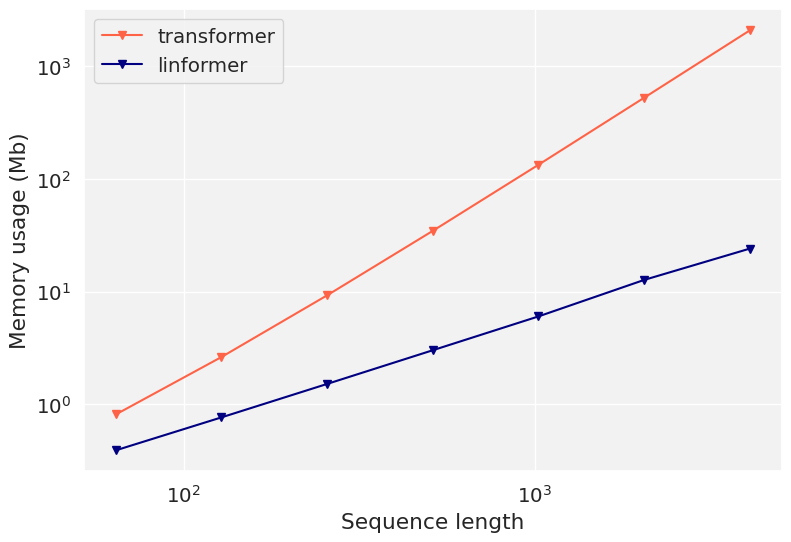

In [49]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(sequence_lengths, mem_usages['transformer'], '-v',
        color='tomato', label='transformer')
ax.plot(sequence_lengths, mem_usages['linformer'], '-v',
        color='navy', label='linformer')
# define x,y label
ax.set_xlabel('Sequence length')
ax.set_ylabel('Memory usage (Mb)')
# plot in logspace
ax.set_xscale('log');
ax.set_yscale('log');
# plot legend
ax.legend();

Как видно, используемая Трансформером память растет значительно быстрее с ростом длины последовательности.

**Задание 8 (0.1 балла):** обучите `Linformer` на том же самом датасете.

In [50]:
# model hyperparams
embed_dim = 64
num_heads = 2
feedforward_dim = 120
num_layers = 3
proj_dim = 16
# the same as for transformer task
sequence_length = 256

In [51]:
model = LinformerForSequenceClassification(
    num_classes=1,
    input_dim=vocab_length,
    embed_dim=embed_dim,
    num_heads=num_heads,
    feedforward_dim=feedforward_dim,
    sequence_length=(sequence_length + 1),
    proj_dim=proj_dim,
    activation=nn.ReLU,
    num_layers=num_layers,
)
# put model on device
model = model.to(device)

In [52]:
num_epochs = 30
warmup_steps = 2000
lr = 5e-5

In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)

In [54]:
scheduler = CosineAnnealingWithWarmupLR(
    optimizer,
    warmup_steps=warmup_steps,
    max_steps=int(num_epochs * len(train_loader))
)

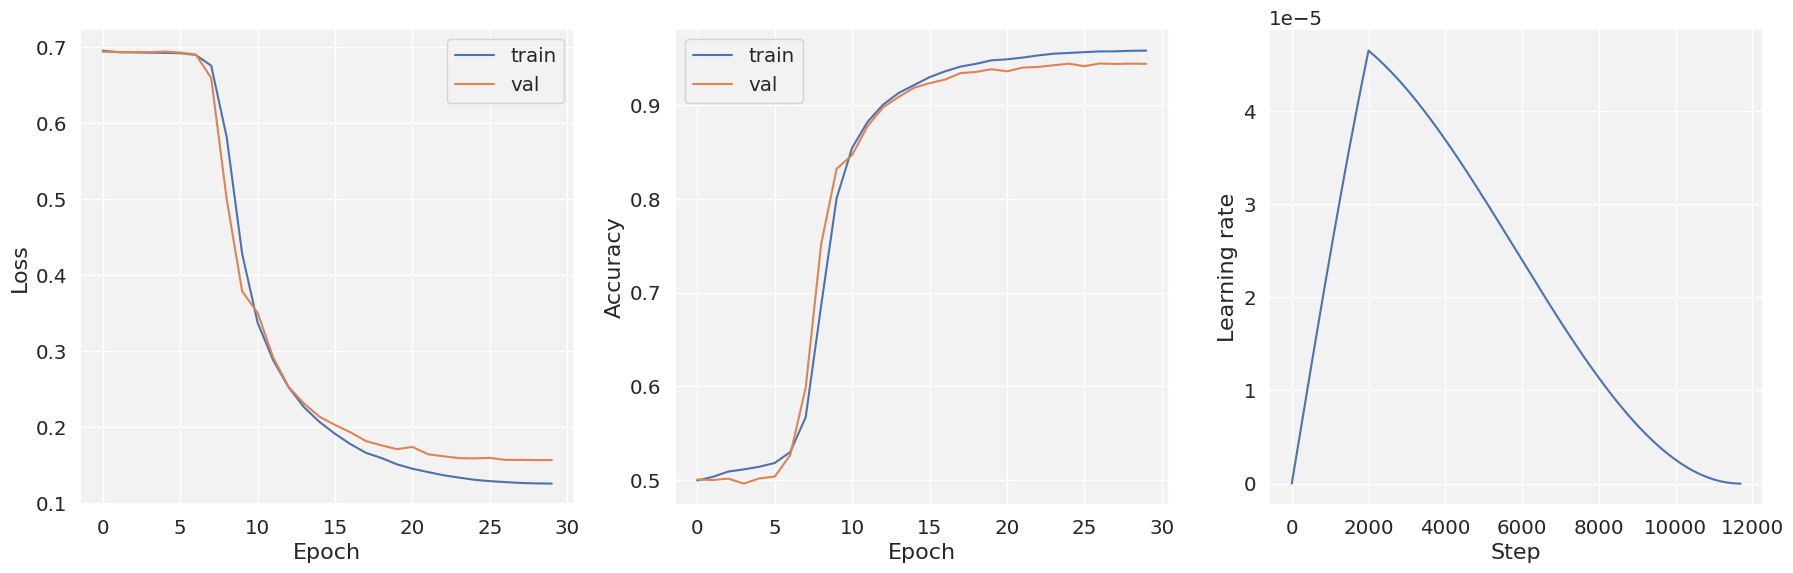

In [55]:
train(
    model,
    num_epochs=num_epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device
)

Если все было реализовано правильно, `Linformer` должен так же успешно справляться с задачей определения палиндрома.